# Quick notebook for testing T-SAM with new optimal OVAM embeddings


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
# general imports
import numpy as np
import pandas as pd
import torch

from diffusers import StableDiffusionPipeline

import os
import shutil

print(torch.version.cuda)

12.8


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

#### TSAM imports based on run python file

In [5]:
# the following code enables imports from the folders in the repository
# NOTE: this only affects the active kernel, not actual system path
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

In [6]:
print(project_root)

/home/lhelder/vision_class/Project/CS5864-diffusion-control


In [7]:
import matplotlib.pyplot as plt
import torch
import os
import torch.nn.functional as F
from typing import List


from tsam.utils import (load_model,
                       save_image,
                       save_text_sa_avg,
                       get_token_ids,
                       LatentOptConfig)

import argparse
import yaml

$$ $$

$$ $$

$$ $$

## Model load in based on run file

In [8]:
from tsam.run import run_one_prompt

In [9]:
with open('../../tsam/configs/config.yaml','r') as f:
    config_dict = yaml.safe_load(f)
    
latent_opt_config = LatentOptConfig(**config_dict)


pipe = load_model(model_name='sd1_5x_2', device=device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

$$ $$

# Load optimized embedding files

**NOTE:** The optimized embeddings for "male" are (2,768) since they also include the start token, so I index to take the second token, which should be the one we care about

In [10]:
opt_embed_path = '../brandon_v1/'
opt_male = np.load(f'{opt_embed_path}optimal_male_embedding.npy')[1]
opt_female = np.load(f'{opt_embed_path}optimal_female_embedding.npy')[1]

In [11]:
opt_male.shape

(768,)

In [12]:
male_input_ids = pipe.tokenizer("male",
                padding="max_length",
                max_length=pipe.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            ).input_ids
male_input_ids = male_input_ids.to(pipe.text_encoder.device)
male_embed = pipe.text_encoder(male_input_ids, attention_mask=None)
male_embed = male_embed.last_hidden_state[0,1,:]

female_input_ids = pipe.tokenizer("female",
                padding="max_length",
                max_length=pipe.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            ).input_ids
female_input_ids = female_input_ids.to(pipe.text_encoder.device)
female_embed = pipe.text_encoder(female_input_ids, attention_mask=None)
female_embed = female_embed.last_hidden_state[0,1,:]

$$ $$

## Overview for creating optimized male and female prompts

Simply:
- encode a prompt: ____ "male"
- replace the "male" embedding with the opt_male embedding

This probably screws with the attention matrices within the encoder, but should be fine for us.

$$ $$

I'm going to do all this in the TSAM code with the following dictionary list input for a bias:

[male_bias, female_bias]

each dictionary has:
- word : male/female
- opt_embedding : numpy (768,)

we will also take in an argument of a bias prompt in the form "a photo of a {}"


$$ $$

$$ $$

$$ $$

In [13]:
# do run_one_prompt code with reduced version
def bias_reduced_generation(main_prompt, occupation_info, bias_prompt_form, bias_info, num_inference_steps=50):

    pipe.text_encoder.to(device)
        
    # sd 1.5 option
    pipe.attn_fetch_x.set_processor(unet = pipe.unet)
    
    steps_to_save_attention_maps = list(range(num_inference_steps))
    
    max_iter_to_alter = latent_opt_config.max_iter_to_alter
    iterative_refinement_steps = latent_opt_config.iterative_refinement_steps
    
    if not latent_opt_config.update_latent:
        max_iter_to_alter = 0
        iterative_refinement_steps = []
    
    image, all_maps = pipe.bias_reduced_call(
        prompt=main_prompt,
        generator=torch.Generator(device).manual_seed(1234),
        num_inference_steps=num_inference_steps,
        max_iter_to_alter=max_iter_to_alter,
        steps_to_save_attention_maps=steps_to_save_attention_maps,
        latent_opt_config = latent_opt_config,

        bias_prompt_form=bias_prompt_form,
        bias_info=bias_info,
        occupation_info=occupation_info,
    )

    return image, all_maps

$$ $$

$$ $$

## Bias generation setup


Current attributes used from latent_opt_config:
- show_first_bias_map
    - Whether to display UNet cross attentions at beginning of bias reduction iterations
- show_last_bias_map
    - Whether to display UNet cross attentions after bias reduction iterations
- bias_refinement_steps
    - List of generation steps to run bias reduction iteration loop
- bias_loss_threshold
    - float loss threshold for when to break bias loss iteration loop
    - 


$$ $$
latent_opt_config.bias_loss_function_details is a dictionary with the following optional keys
   - display: all or one
       - whether to display all UNet cross attention layers or just the ones being used for loss function
   - separate_scales: True or False, default False
       - whether the groups of displayed cross attention maps should use the same color scale
   - max_cnt: int, default 30
       - maximum interation count for bias loss iterations
   - block_class: None, 'CrossAttnUpBlock2D' or 'CrossAttnDownBlock2D'
       - block class to grab cross attentions from
       - None defaults to T-SAM default of using both bottle neck layers
       - **NOTE:** I haven't implemented being able to choose multiple UNet blocks or interpolating between them
   - total_map_size: 16\*16, 32\*32, 64\*64
       - total map size of desired cross attention layer (s*s)
       - not required if block_class is None


num_warmup_steps: 1


  0%|          | 0/50 [00:00<?, ?it/s]

Iter 0, T-SAM attn loss: 1.7900390625
updated latent (step 0)
Iter 1, T-SAM attn loss: 1.7861328125
updated latent (step 1)
Iter 2, T-SAM attn loss: 1.78515625
updated latent (step 2)
Iter 3, T-SAM attn loss: 1.775390625
updated latent (step 3)
Iter 4, T-SAM attn loss: 1.763671875
updated latent (step 4)
Iter 5, T-SAM attn loss: 1.76953125
Starting bias iterative refinement for step: 5
ca map shape: (64, 64)


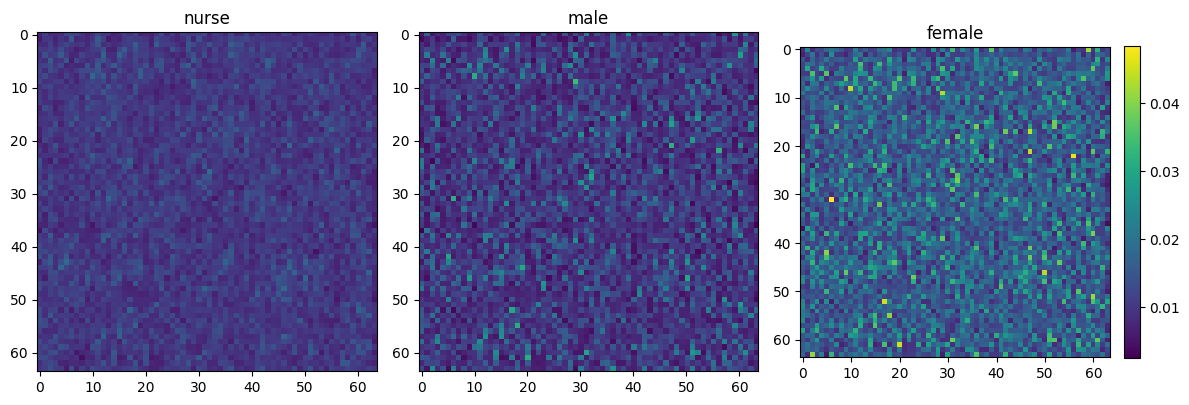

ca map shape: (32, 32)


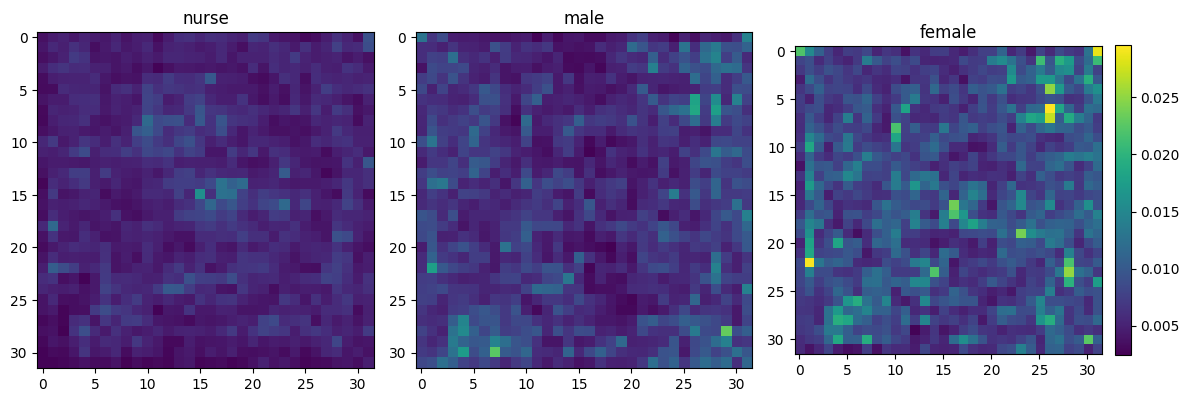

ca map shape: (16, 16)


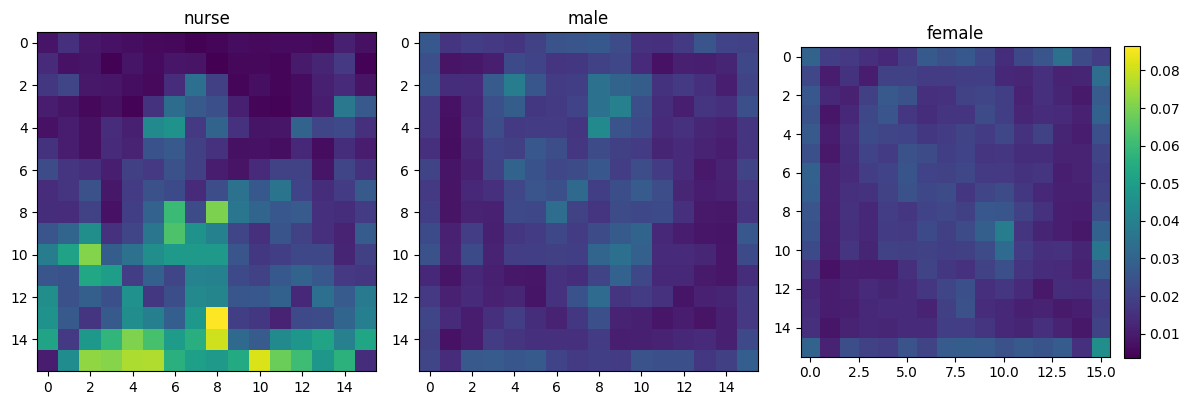

ca map shape: (16, 16)


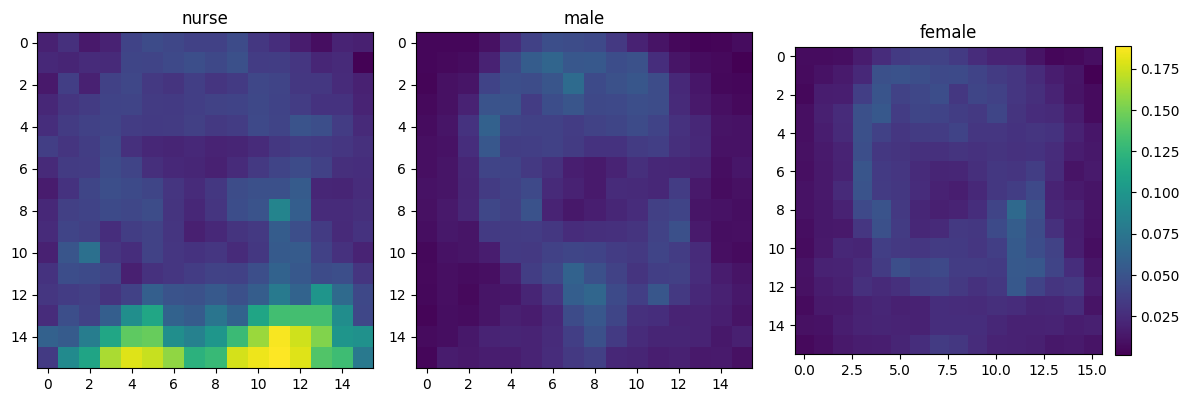

ca map shape: (32, 32)


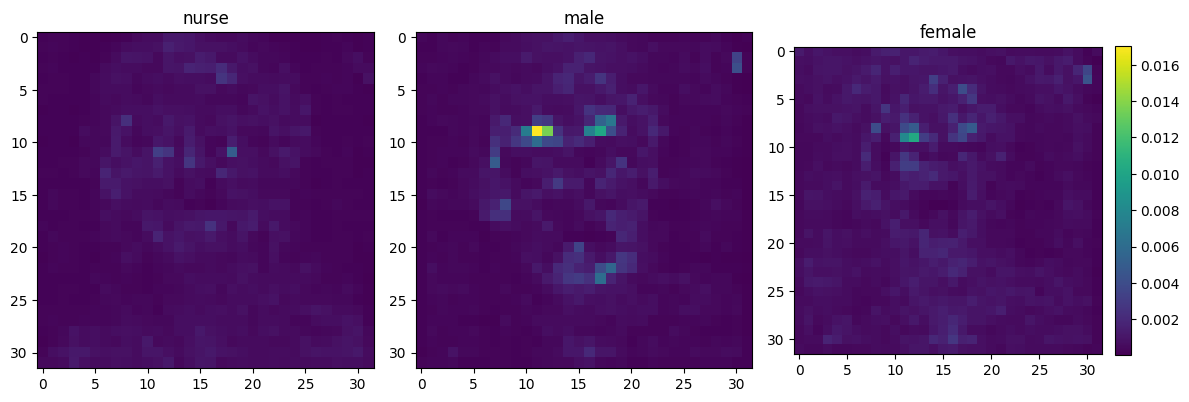

ca map shape: (64, 64)


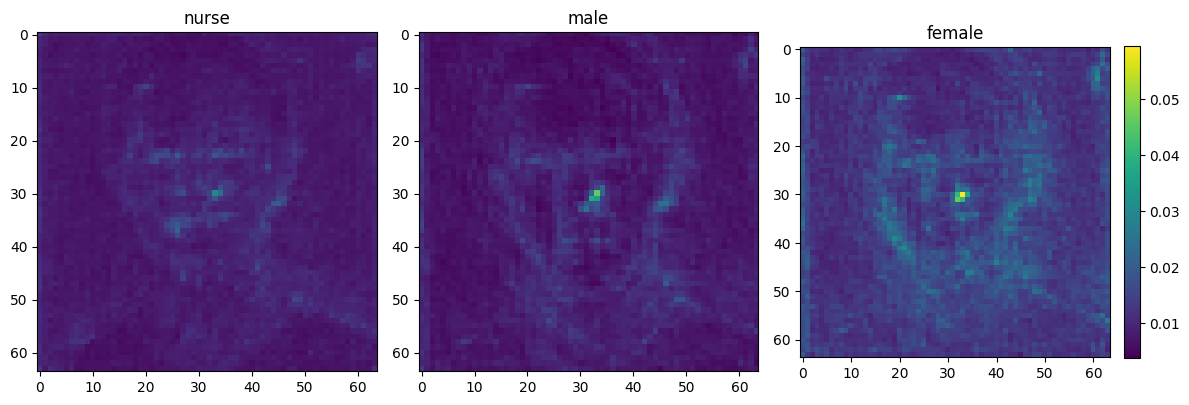

b1: 0.699, 0.984, 0.018, b2: 0.740, 1.015, 0.019
mse loss: 0.06085205078125
bias loss iter 0: 0.06085205078125
b1: 0.645, 1.038, 0.020, b2: 0.658, 0.962, 0.019
mse loss: 0.035003662109375
bias loss iter 1: 0.035003662109375
bias loss breaking from loss < 0.05
T-SAM loss after BIAS iter refinement: 1.765625
updated latent (step 5)
Iter 6, T-SAM attn loss: 1.763671875
Starting bias iterative refinement for step: 6
ca map shape: (64, 64)


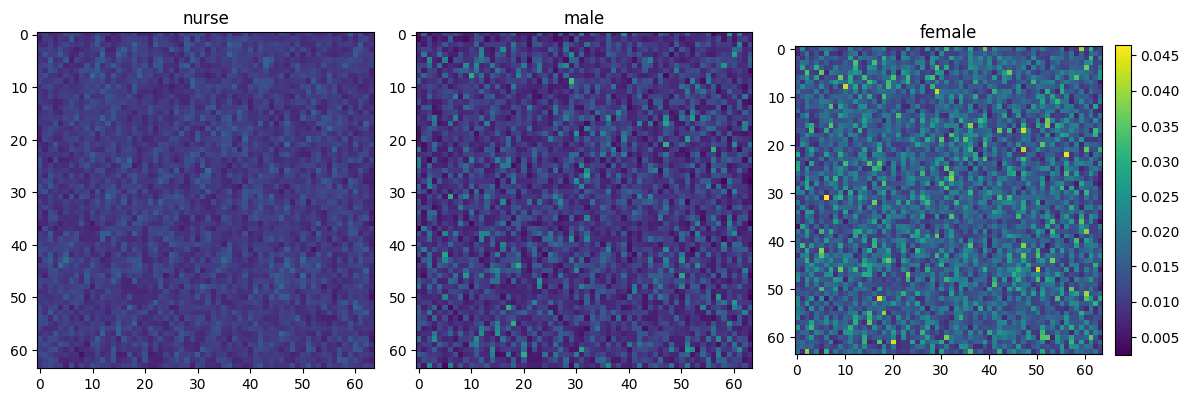

ca map shape: (32, 32)


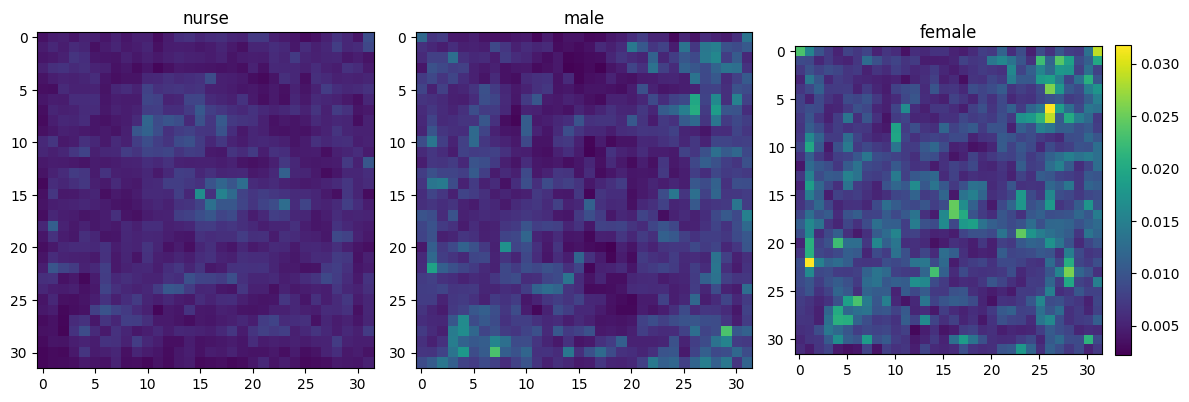

ca map shape: (16, 16)


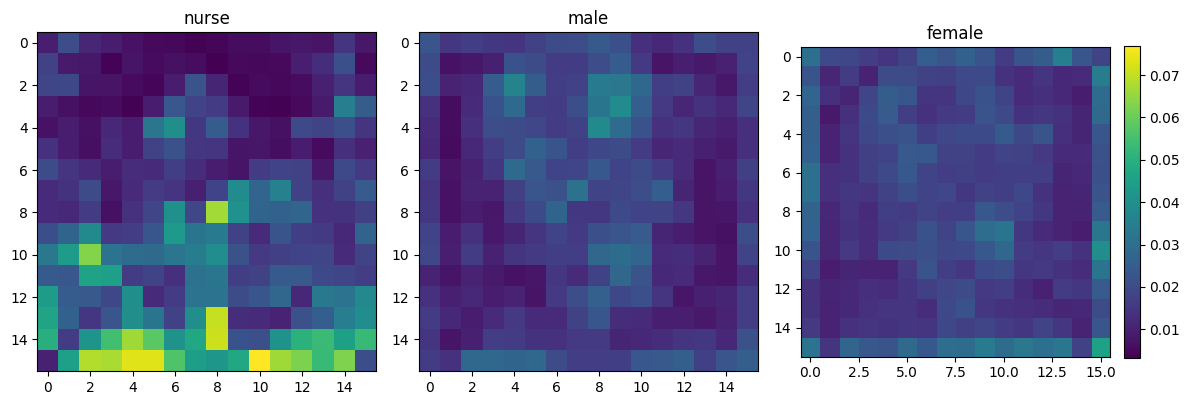

ca map shape: (16, 16)


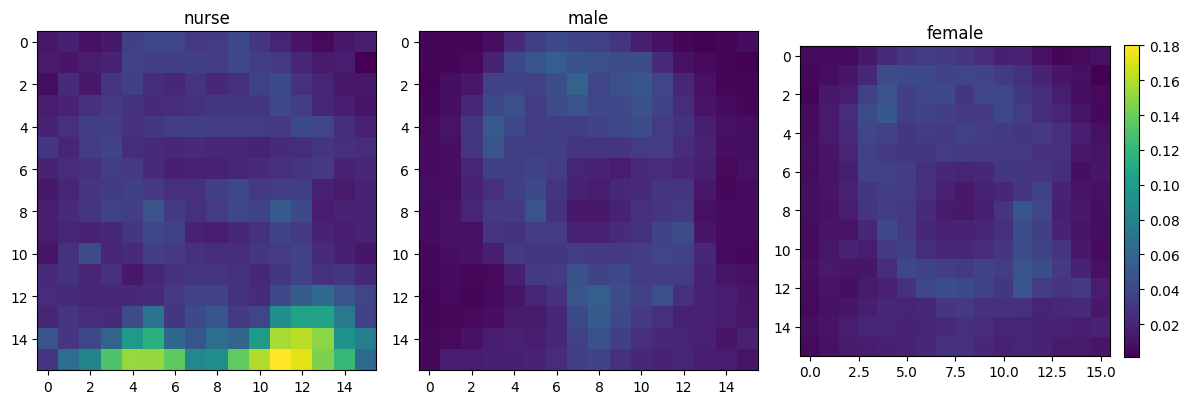

ca map shape: (32, 32)


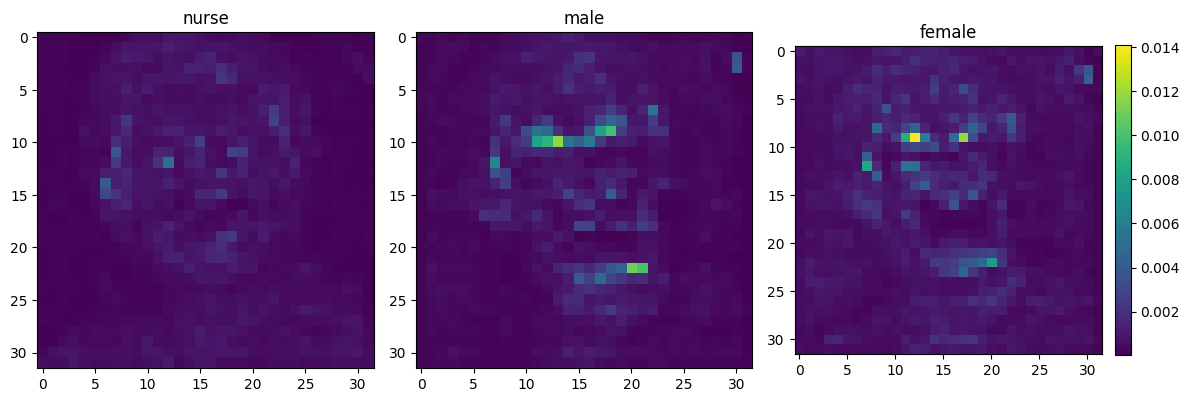

ca map shape: (64, 64)


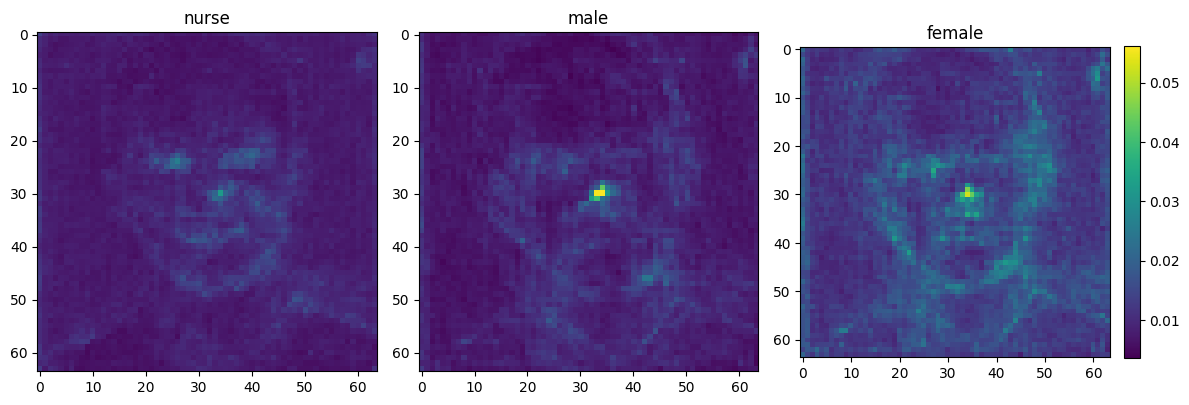

b1: 0.682, 0.999, 0.016, b2: 0.715, 1.000, 0.016
mse loss: 0.048828125
bias loss iter 0: 0.048828125
bias loss breaking from loss < 0.05
T-SAM loss after BIAS iter refinement: 1.763671875
updated latent (step 6)
Iter 7, T-SAM attn loss: 1.74609375
Starting bias iterative refinement for step: 7
ca map shape: (64, 64)


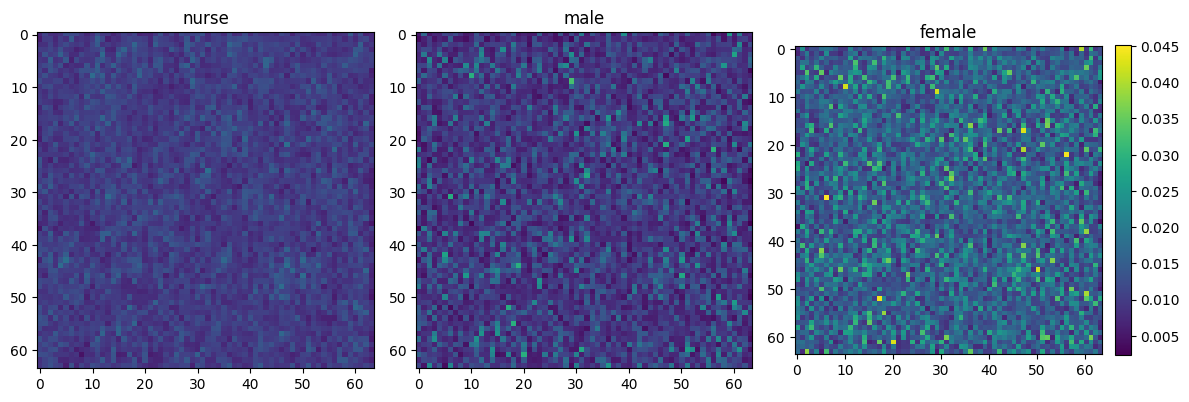

ca map shape: (32, 32)


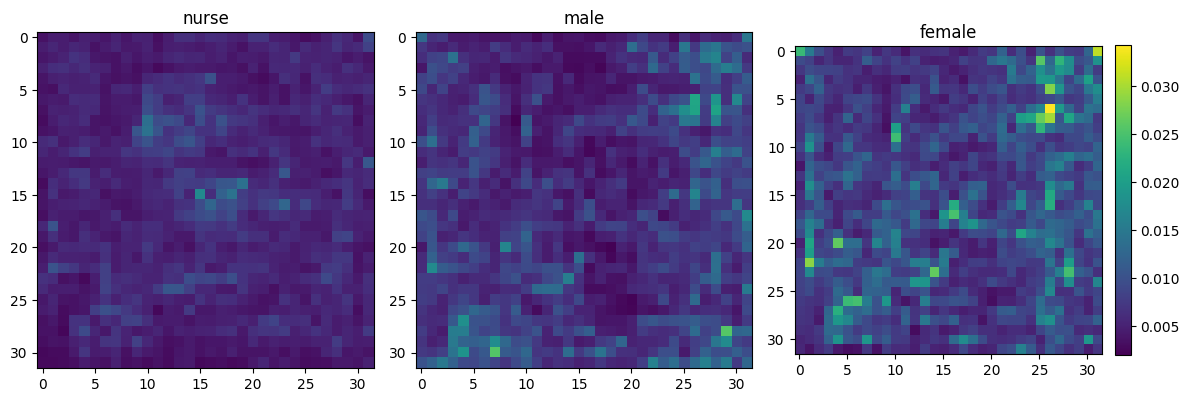

ca map shape: (16, 16)


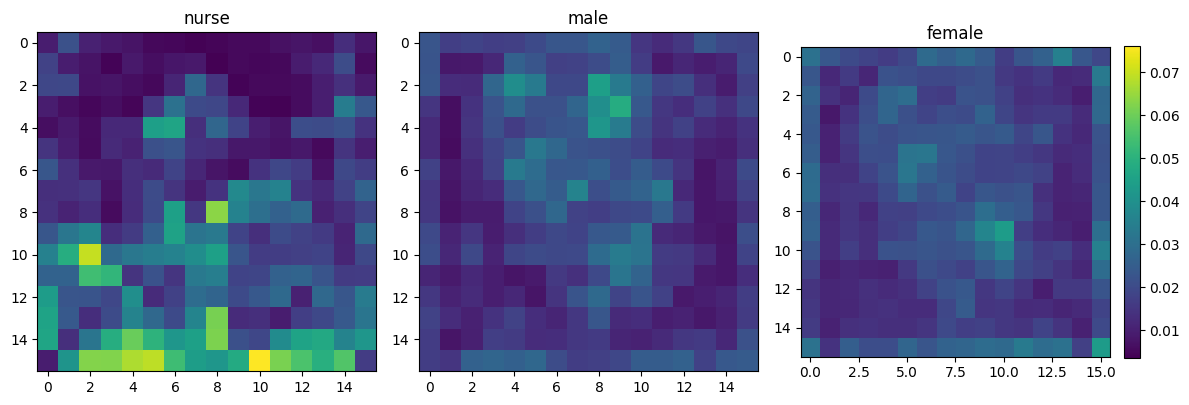

ca map shape: (16, 16)


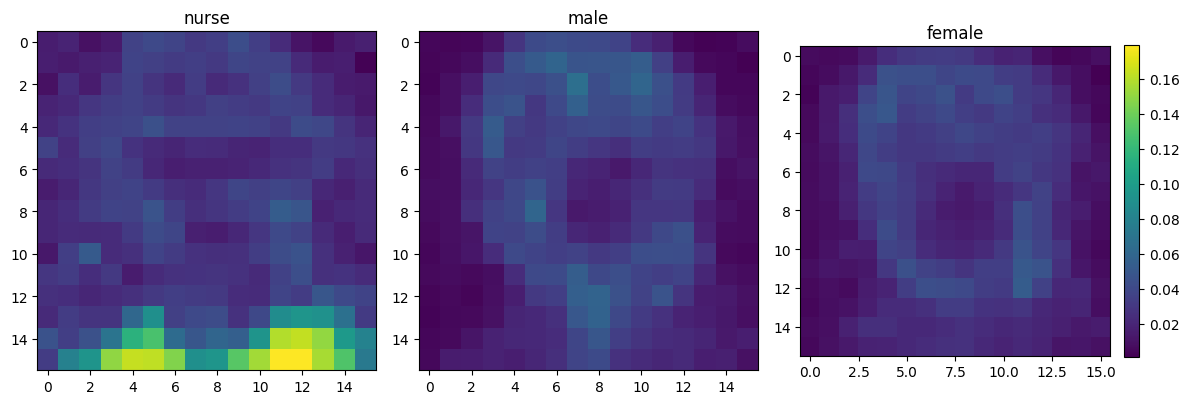

ca map shape: (32, 32)


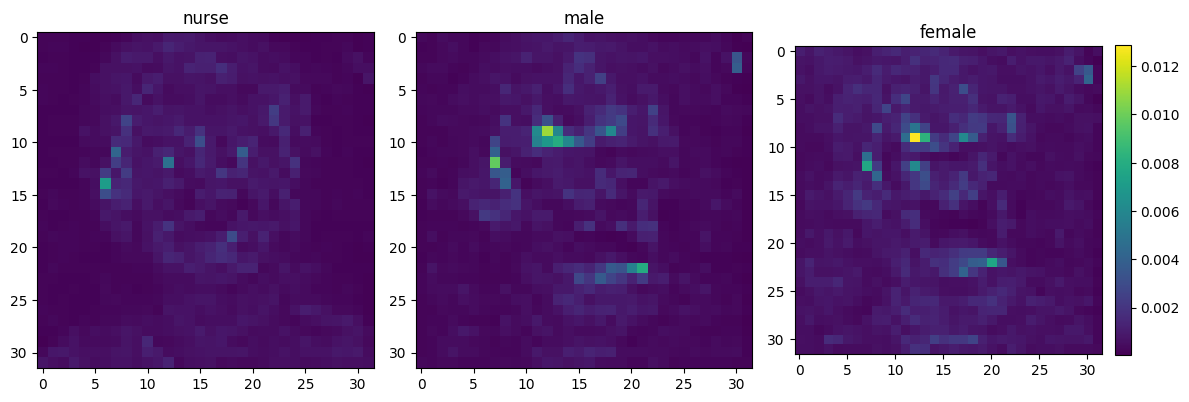

ca map shape: (64, 64)


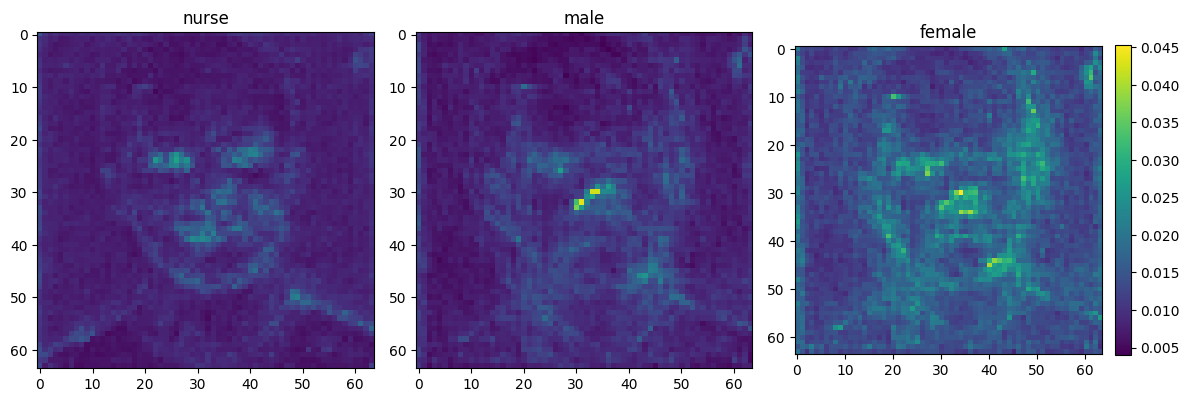

b1: 0.676, 1.039, 0.018, b2: 0.707, 0.962, 0.017
mse loss: 0.035400390625
bias loss iter 0: 0.035400390625
bias loss breaking from loss < 0.05
T-SAM loss after BIAS iter refinement: 1.74609375
updated latent (step 7)
Iter 8, T-SAM attn loss: 1.7734375
Starting bias iterative refinement for step: 8
ca map shape: (64, 64)


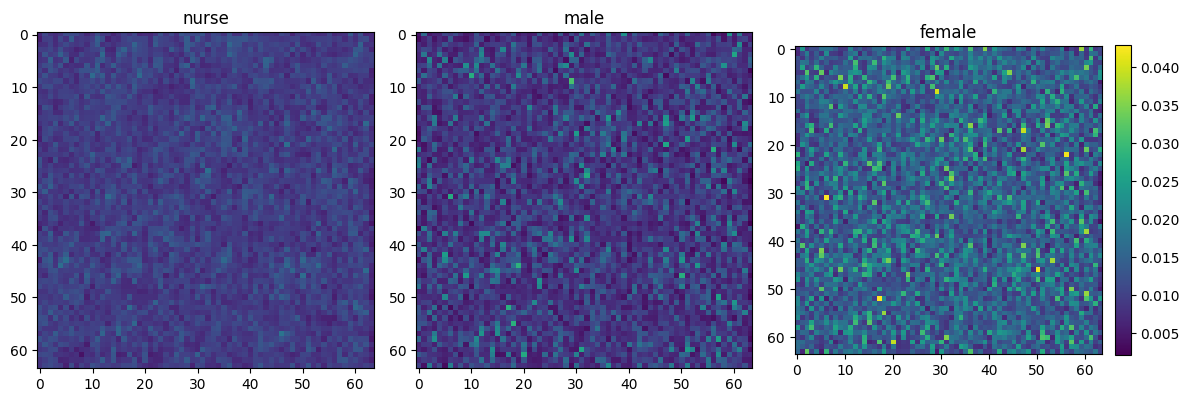

ca map shape: (32, 32)


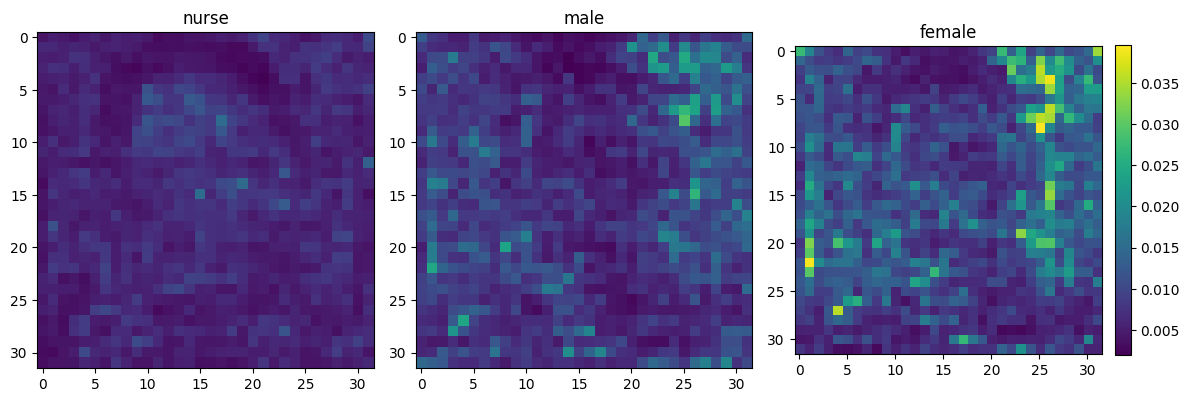

ca map shape: (16, 16)


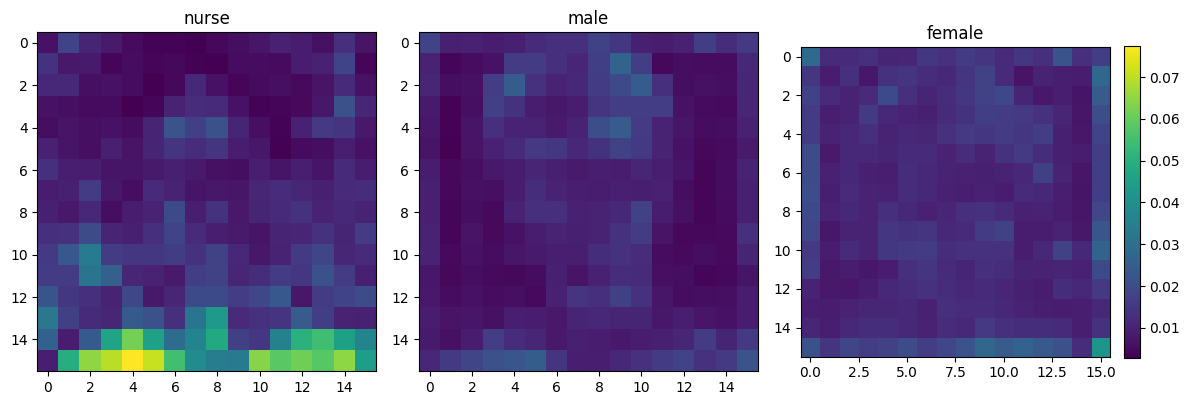

ca map shape: (16, 16)


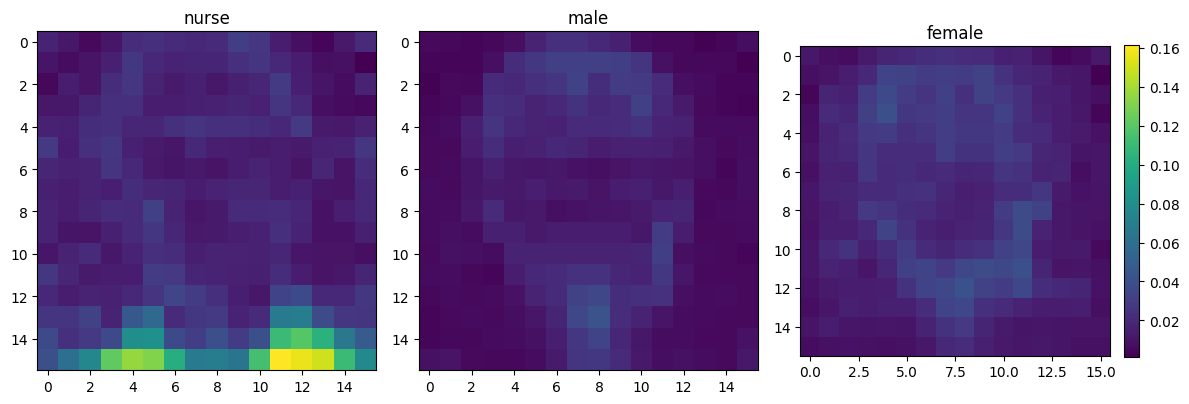

ca map shape: (32, 32)


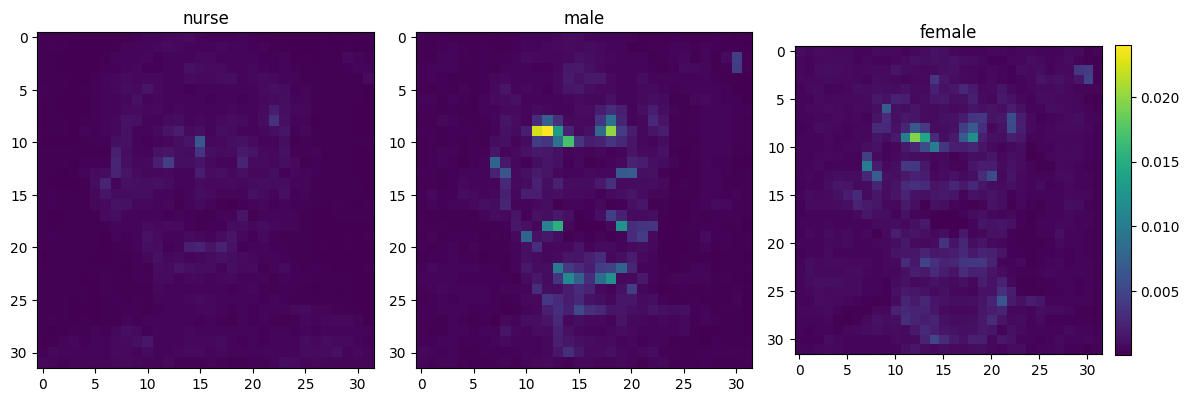

ca map shape: (64, 64)


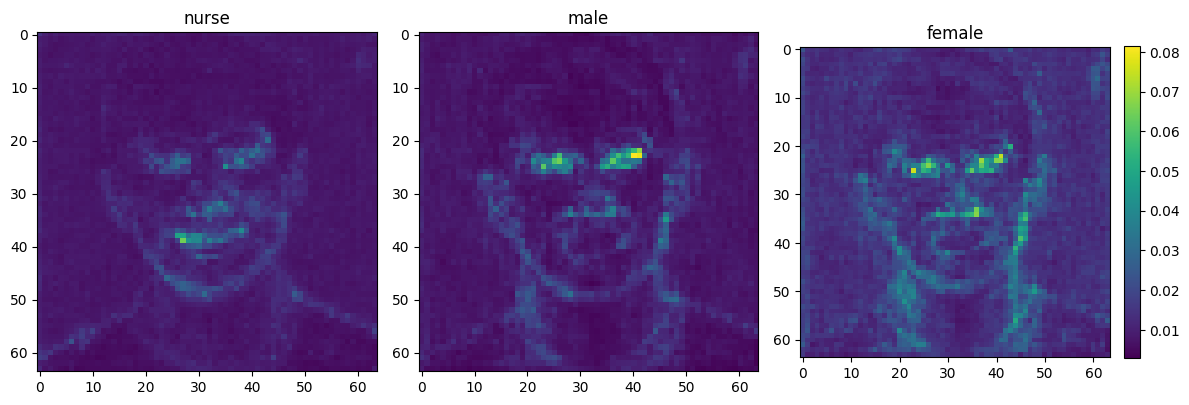

b1: 0.574, 0.810, 0.009, b2: 0.600, 1.190, 0.013
mse loss: 0.171142578125
bias loss iter 0: 0.171142578125
b1: 0.580, 0.911, 0.011, b2: 0.613, 1.089, 0.013
mse loss: 0.09881591796875
bias loss iter 1: 0.09881591796875
b1: 0.578, 0.984, 0.011, b2: 0.621, 1.016, 0.012
mse loss: 0.056976318359375
bias loss iter 2: 0.056976318359375
b1: 0.574, 1.047, 0.012, b2: 0.620, 0.953, 0.011
mse loss: 0.032958984375
bias loss iter 3: 0.032958984375
bias loss breaking from loss < 0.05
T-SAM loss after BIAS iter refinement: 1.7568359375
updated latent (step 8)
Iter 9, T-SAM attn loss: 1.73828125
Starting bias iterative refinement for step: 9
ca map shape: (64, 64)


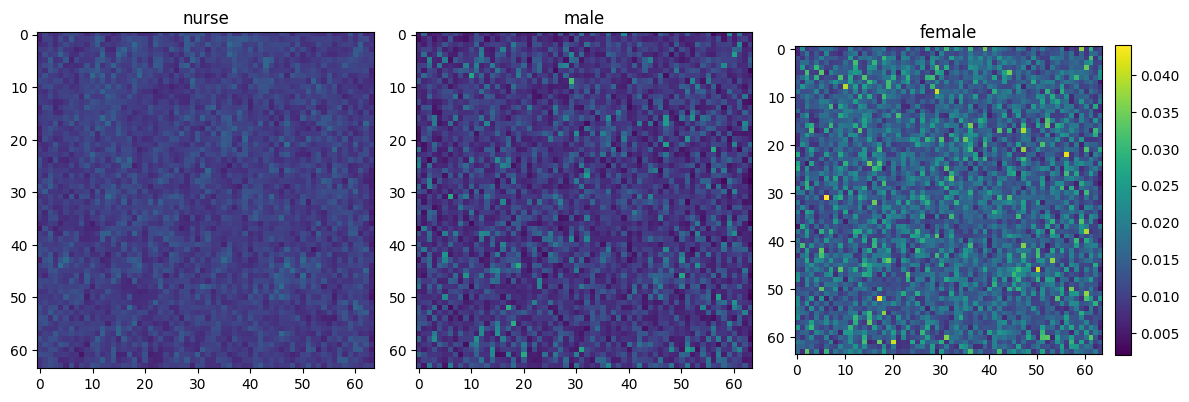

ca map shape: (32, 32)


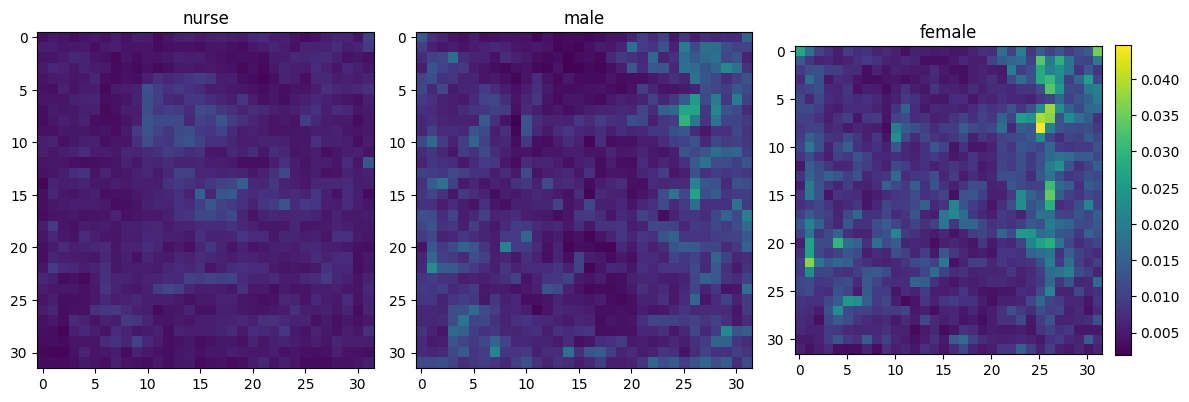

ca map shape: (16, 16)


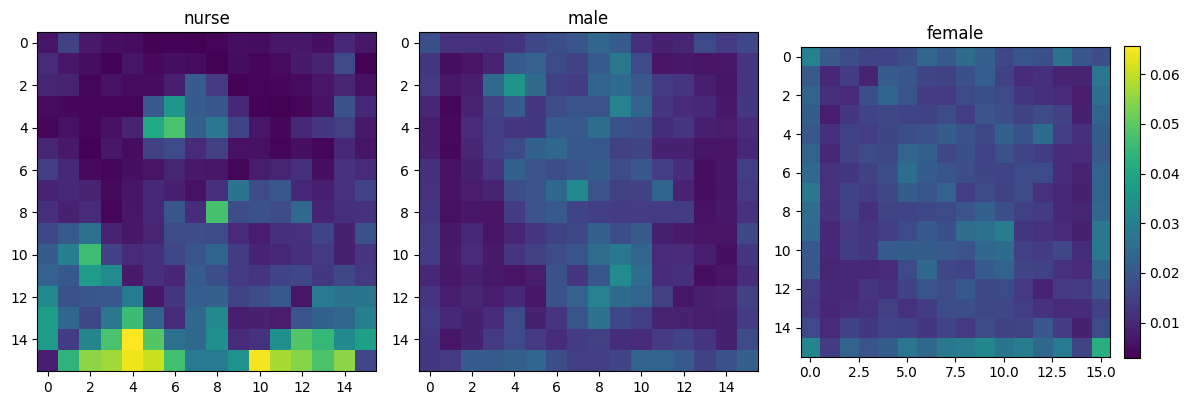

ca map shape: (16, 16)


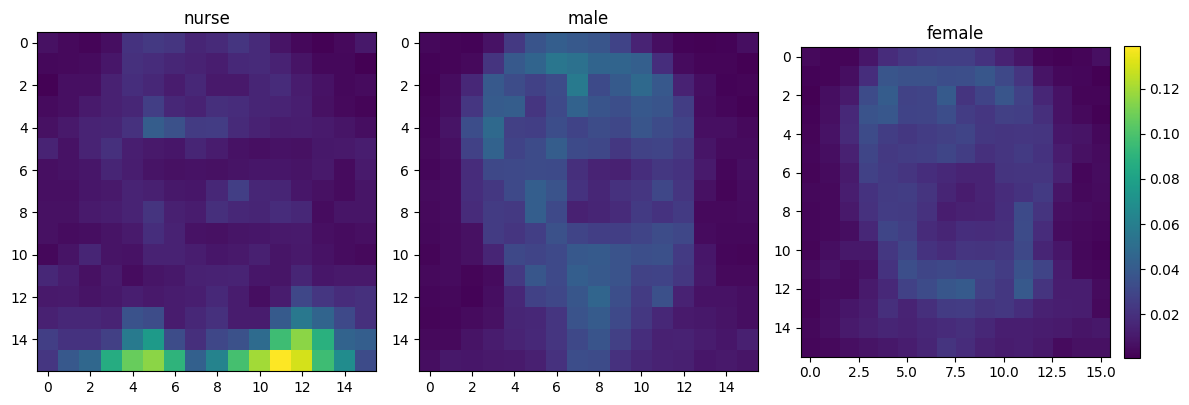

ca map shape: (32, 32)


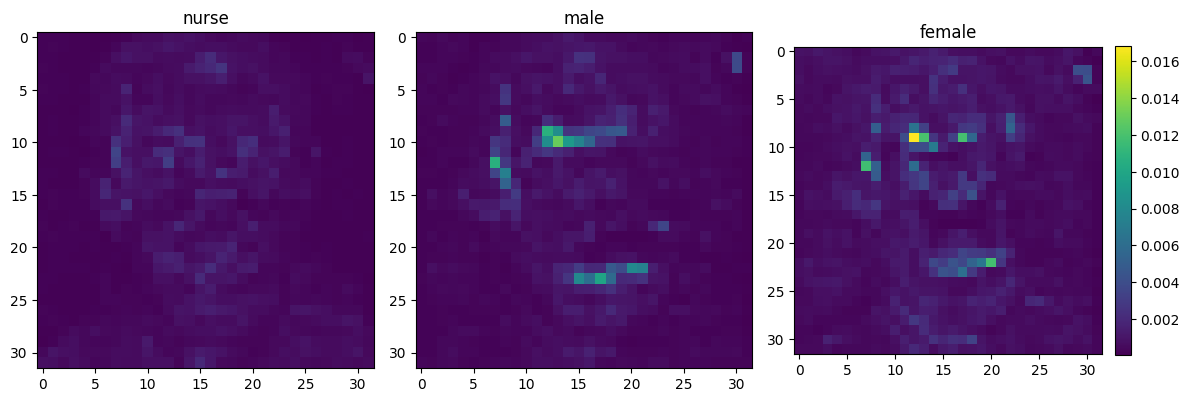

ca map shape: (64, 64)


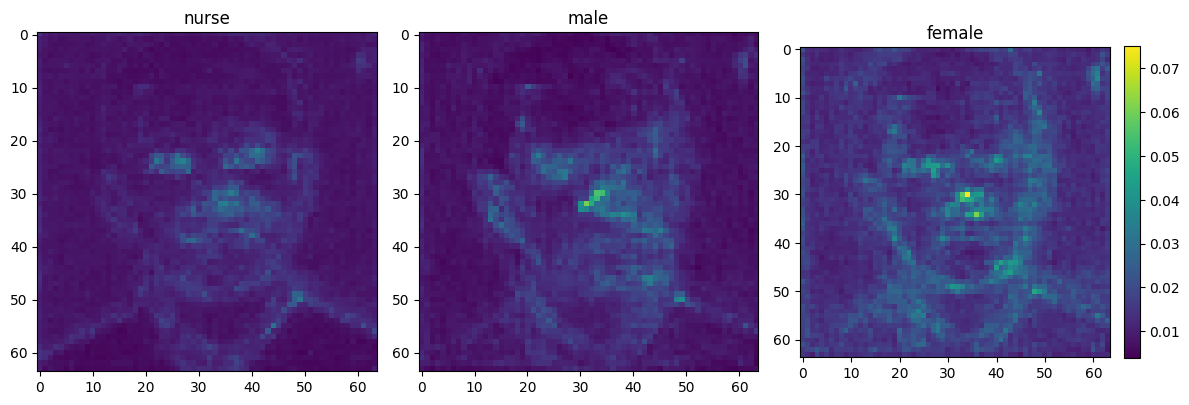

b1: 0.520, 1.092, 0.014, b2: 0.551, 0.909, 0.012
mse loss: 0.02423095703125
bias loss iter 0: 0.02423095703125
bias loss breaking from loss < 0.05
T-SAM loss after BIAS iter refinement: 1.73828125
updated latent (step 9)
Iter 10, T-SAM attn loss: 1.765625
Starting bias iterative refinement for step: 10
ca map shape: (64, 64)


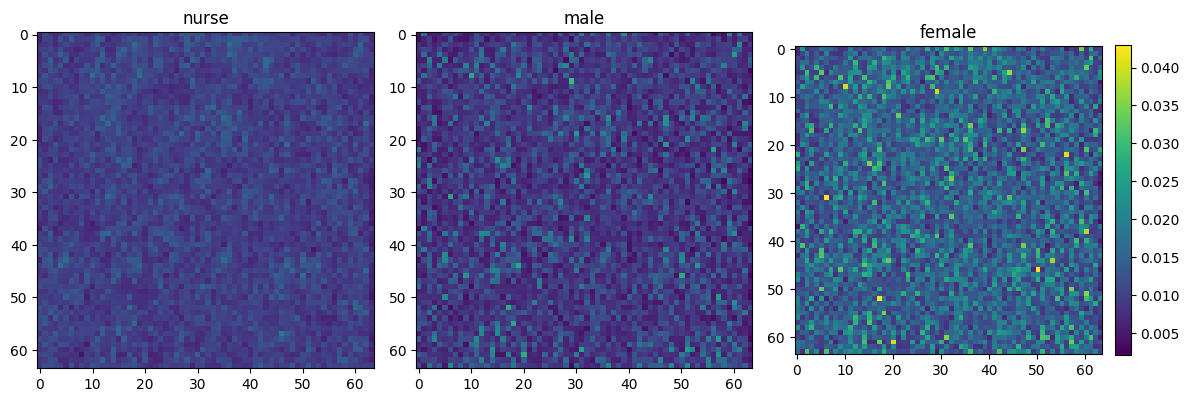

ca map shape: (32, 32)


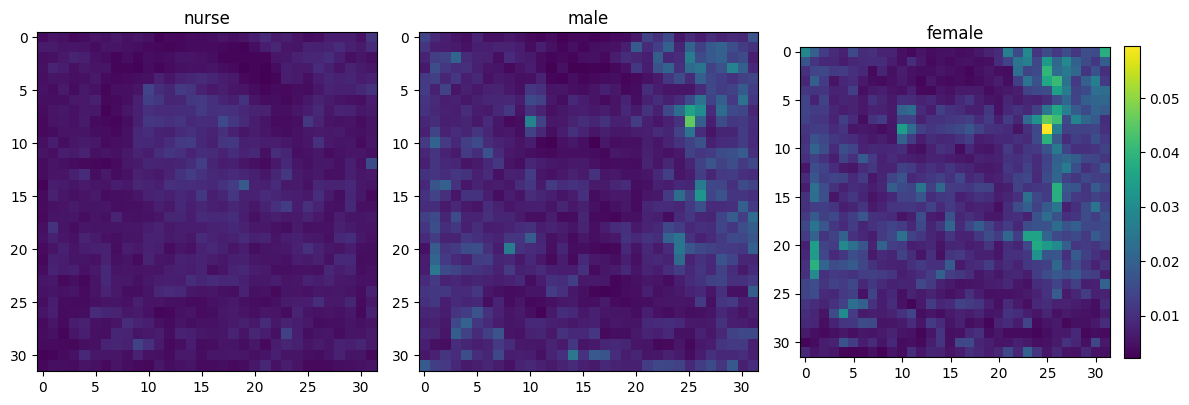

ca map shape: (16, 16)


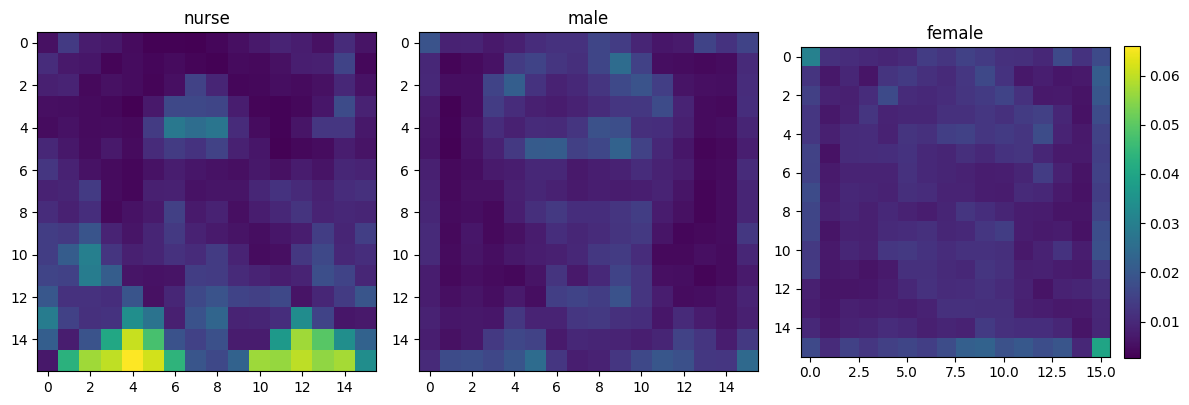

ca map shape: (16, 16)


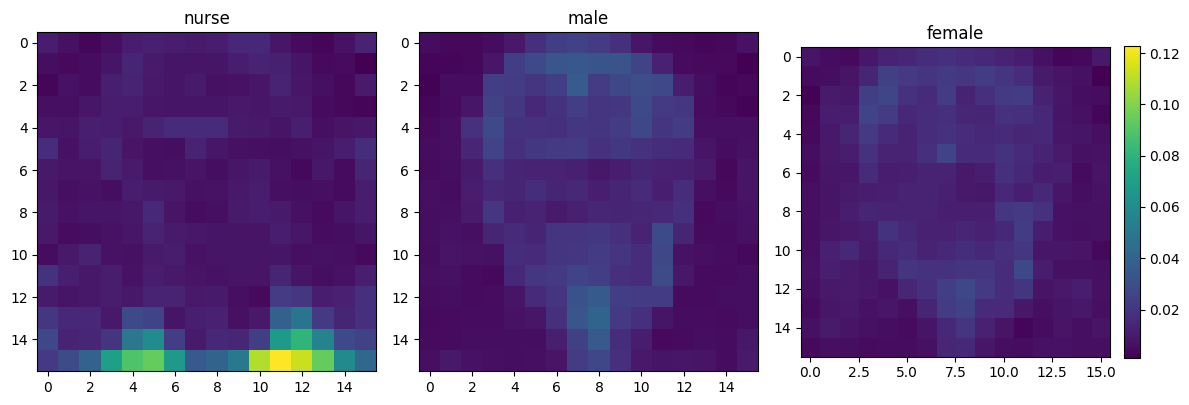

ca map shape: (32, 32)


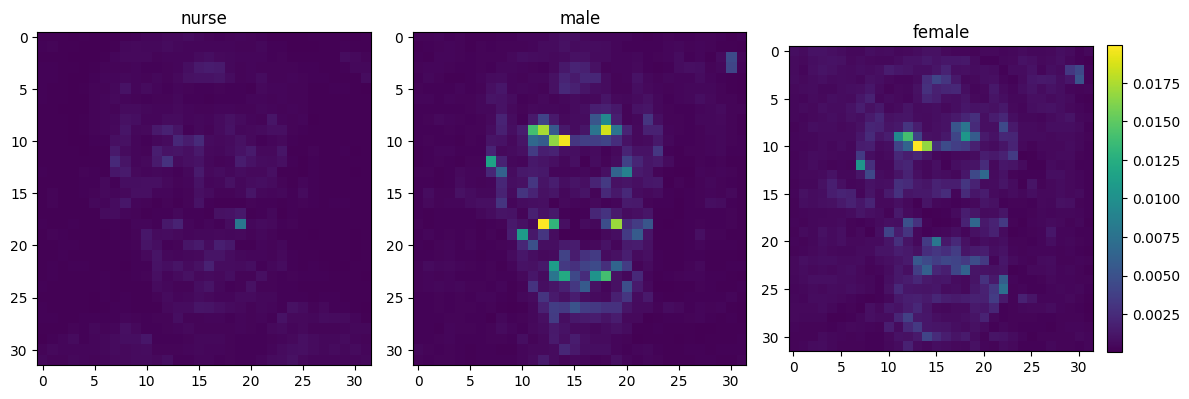

ca map shape: (64, 64)


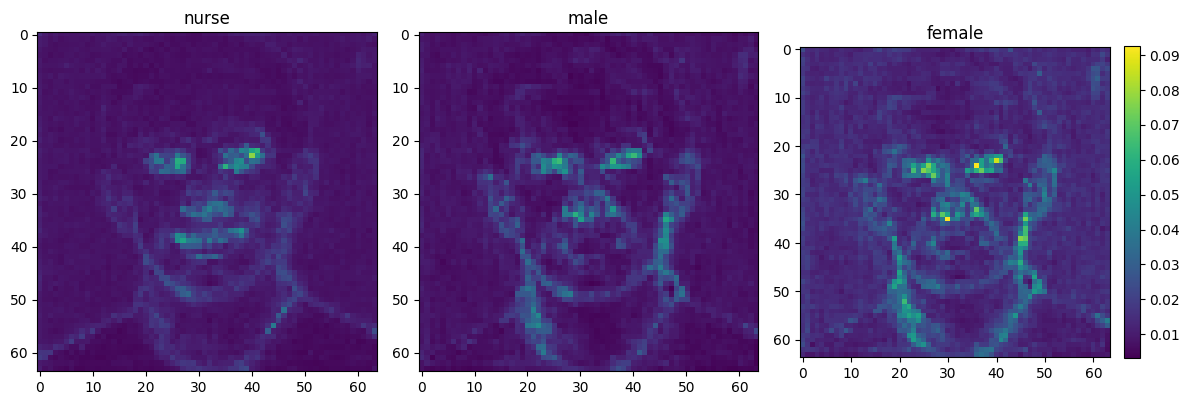

b1: 0.467, 1.041, 0.009, b2: 0.520, 0.958, 0.009
mse loss: 0.03485107421875
bias loss iter 0: 0.03485107421875
bias loss breaking from loss < 0.05
T-SAM loss after BIAS iter refinement: 1.765625
updated latent (step 10)
Iter 11, T-SAM attn loss: 1.7265625
updated latent (step 11)
Iter 12, T-SAM attn loss: 1.7470703125
updated latent (step 12)
Iter 13, T-SAM attn loss: 1.7333984375
updated latent (step 13)
Iter 14, T-SAM attn loss: 1.7294921875
updated latent (step 14)
Iter 15, T-SAM attn loss: 1.71484375
updated latent (step 15)
Iter 16, T-SAM attn loss: 1.7060546875
updated latent (step 16)
Iter 17, T-SAM attn loss: 1.689453125
updated latent (step 17)
Iter 18, T-SAM attn loss: 1.6796875
updated latent (step 18)
Iter 19, T-SAM attn loss: 1.6640625
updated latent (step 19)
Iter 20, T-SAM attn loss: 1.65234375
updated latent (step 20)
Iter 21, T-SAM attn loss: 1.6396484375
updated latent (step 21)
Iter 22, T-SAM attn loss: 1.6279296875
updated latent (step 22)
Iter 23, T-SAM attn loss: 

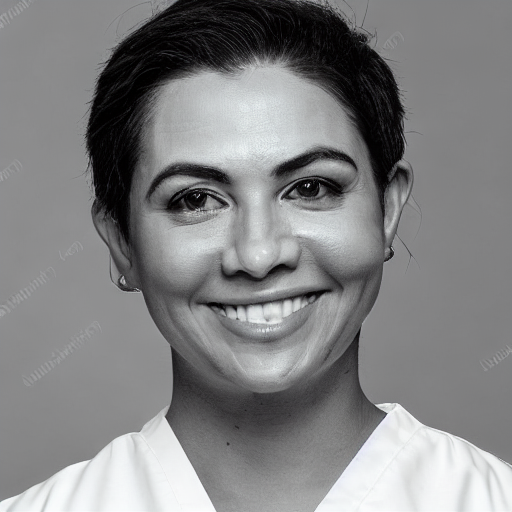

In [27]:
# disable T-SAM iterative function
latent_opt_config.iterative_refinement_steps = []
# latent_opt_config.max_iter_to_alter=

# bias map display settings
latent_opt_config.show_first_bias_map = True
latent_opt_config.show_last_bias_map = False

# latent_opt_config.bias_refinement_steps = [i+5 for i in range(15)]
latent_opt_config.bias_refinement_steps = [5,6,7,8,9,10]

latent_opt_config.bias_loss_function_details = {'display' : 'all',                      # 'all' or default of one
                                                'separate_scales': False,                # True or default of None/False
                                                'block_class': 'CrossAttnUpBlock2D',    # None, 'CrossAttnUpBlock2D' or 'CrossAttnDownBlock2D'
                                                'total_map_size': [16*16],                #  None, 16*16, 32*32, or 64*64
                                                'max_cnt':10
                                                }
latent_opt_config.bias_loss_threshold = 0.05#0.05


main_prompt = "A photo of the face of a nurse"

occupation_info = {'word' : 'nurse'}

bias_prompt_form = "A photo of a {}"
bias_info = [{'word' : 'male',   'opt_embedding' : male_embed},
             {'word' : 'female', 'opt_embedding' : female_embed}]

image, attention_maps = bias_reduced_generation(main_prompt, occupation_info, bias_prompt_form, bias_info, num_inference_steps=50)
image[0]